In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
from sqlalchemy import create_engine
import pandas as pd

In [3]:
engine_sqlite = create_engine('sqlite:///app/posts.db', echo=False)

In [4]:
query_profiles = "SELECT * FROM profiles where label IS NOT NULL"
df = pd.read_sql_query(query_profiles, engine_sqlite)
df.set_index("index", inplace=True)

In [5]:
df.groupby('label').size()

label
facebook           15
google_new         20
google_old        549
miscellaneous     274
self             1093
dtype: int64

In [6]:
def class_to_no(label):
    if label == 'facebook':
        return 0
    elif label == 'google_new':
        return 1
    elif label == 'google_old':
        return 2
    elif label == 'miscellaneous':
        return 3
    elif label == 'self':
        return 4
    

In [7]:
df['label_num'] = df['label'].apply(class_to_no)

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import urllib
import urllib.request as ur
from PIL import Image 
import requests
from io import BytesIO
import random

In [9]:
def convert_picture(url): 
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img = img.resize((100,100))
        img= img.convert('L')
        return np.array(img)

In [10]:
label_num = np.array(df['label_num'])
set(label_num)

{0, 1, 2, 3, 4}

In [11]:
from keras.utils import to_categorical
label_num_ohe = to_categorical(label_num)
print(label_num_ohe)

Using TensorFlow backend.


[[0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [12]:
images = []

for img_url in np.array(df['profile_picture_url']):
    image = convert_picture(img_url)
    images.append(image)

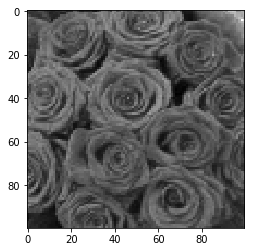

In [13]:
plt.imshow(images[77], cmap='gray')
plt.show()

In [14]:
images = np.array(images)
images.shape

(1951, 100, 100)

In [15]:
images = images.reshape(-1, 100, 100, 1)

In [16]:
images.shape

(1951, 100, 100, 1)

In [17]:
label_num_ohe.shape

(1951, 5)

In [18]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
# print("GPU Available: ", tf.test.is_gpu_available())

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, label_num_ohe, test_size=0.20, random_state =42)

In [20]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(1560, 100, 100, 1)
(1560, 5)
(391, 100, 100, 1)
(391, 5)


In [21]:
x_train = x_train/255.0
x_test = x_test/255.0

In [22]:
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape=x_train.shape[1:], activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(8, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

W1003 10:11:36.133229 139737121220416 deprecation_wrapper.py:119] From /home/gunnika/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1003 10:11:36.422283 139737121220416 deprecation_wrapper.py:119] From /home/gunnika/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1003 10:11:36.461241 139737121220416 deprecation_wrapper.py:119] From /home/gunnika/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1003 10:11:36.525193 139737121220416 deprecation_wrapper.py:119] From /home/gunnika/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W10

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
__________

In [24]:
weights = np.array(df.groupby('label').size())
w = weights.sum()/weights

In [25]:
class_weight = {0: w[0],
               1: w[1],
               2: w[2],
               3: w[3],
               4: w[4]}

In [29]:
model.fit(x_train,y_train, epochs= 80, validation_split= 0.20, batch_size=20, class_weight = class_weight)

Train on 1248 samples, validate on 312 samples
Epoch 1/80
1248/1248 [==============================] - 2s 1ms/step - loss: 0.1419 - acc: 0.9968 - val_loss: 7.2145 - val_acc: 0.8173
Epoch 2/80
1248/1248 [==============================] - 1s 1ms/step - loss: 0.1441 - acc: 0.9968 - val_loss: 7.0799 - val_acc: 0.8045
Epoch 3/80
1248/1248 [==============================] - 1s 1ms/step - loss: 0.1261 - acc: 0.9984 - val_loss: 7.1673 - val_acc: 0.8013
Epoch 4/80
1248/1248 [==============================] - 1s 1ms/step - loss: 0.1660 - acc: 0.9960 - val_loss: 6.7993 - val_acc: 0.7949
Epoch 5/80
1248/1248 [==============================] - 1s 1ms/step - loss: 0.1538 - acc: 0.9952 - val_loss: 7.6007 - val_acc: 0.8013
Epoch 6/80
1248/1248 [==============================] - 1s 1ms/step - loss: 0.1308 - acc: 0.9968 - val_loss: 7.7801 - val_acc: 0.7917
Epoch 7/80
1248/1248 [==============================] - 2s 1ms/step - loss: 0.1208 - acc: 0.9976 - val_loss: 7.9993 - val_acc: 0.8013
Epoch 8/80
1248

In [30]:
model.evaluate(x_test, y_test)

391/391 [==============================] - 0s 882us/step


[1.8770249170415543, 0.7928388747565277]

In [31]:
model.metrics_names

['loss', 'acc']

In [32]:
def test_image(url):
    categories = ['facebook', 'google_old', 'google_new', 'miscellaneous', 'self' ]
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((100,100))
    img= img.convert('L')
    img = np.array(img)
    img = img.reshape(-1, 100, 100, 1)
    predictions= model.predict(img)
    return categories[predictions.argmax()]

In [42]:
#self_image = 'https://scontent.fdel21-1.fna.fbcdn.net/v/t1.0-9/19145949_1901818590031524_5854858957661418728_n.jpg?_nc_cat=102&_nc_oc=AQmgLFYJ3IRbfvgww3t4vUDTc_k4K1brtI1ZTg8g1_0ZfuO1RLFhTnwqBp8JNp2dHvs&_nc_ht=scontent.fdel21-1.fna&oh=a28d00cff970b47fec915ca01bd1116e&oe=5DA6326A'
#test_image(self_image)

In [34]:
google_new = 'https://secure.gravatar.com/avatar/bc6e493d17a9bc4ff13b664205a48609?d=https://storage.whmcs.community/monthly_2017_10/A.png.308193d82a68e42c7b4e71fa8a5272f4.png'
test_image(google_new)

/home/gunnika/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


'google_new'

In [35]:
google_old = 'https://i.stack.imgur.com/34AD2.jpg'
test_image(google_old)

'google_old'

In [43]:
#facebook = 'https://www.colibrilife.com/wp-content/uploads/2018/01/no-avatar-female.png'
#test_image(facebook)

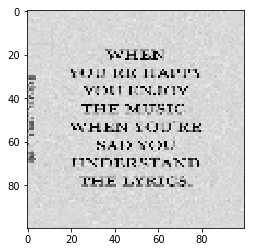

miscellaneous


In [37]:
misc = 'http://wisdomquotes.com/wp-content/uploads/inspirational-quotes-every-next-level-of-your-life-will-demand-a-different-you-wisdom-quotes-1.jpg'

misc2 = 'https://cdn.lifehack.org/wp-content/uploads/2016/02/26042240/Lifehack_Quotes_251429d69c58da436ad9d6ee8bb751d2.jpg'
img = convert_picture(misc2)
plt.imshow(img, cmap='gray')
plt.show()
print(test_image(misc2))

In [1]:
#self2 = 'https://scontent.fdel21-1.fna.fbcdn.net/v/t1.0-9/37919976_2172114239483735_2750643600642539520_n.jpg?_nc_cat=103&_nc_oc=AQlu-b2cQaYYXJ1cFH9Iei7Ocoqc6MG8Kx8BF8tXLKSVeVOndOttmpcjpLs-LOopyH0&_nc_ht=scontent.fdel21-1.fna&oh=7c2119453b6c5ab7e30a6b8c1a42d5d4&oe=5DD5347F'
#test_image(self2)

In [39]:
from sklearn.metrics import classification_report

pred = model.predict(x_test)
print(classification_report(np.argmax(pred, axis=1), np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5
           2       1.00      0.96      0.98       106
           3       0.34      0.27      0.30        63
           4       0.79      0.86      0.82       216

   micro avg       0.79      0.79      0.79       391
   macro avg       0.83      0.82      0.82       391
weighted avg       0.78      0.79      0.78       391



In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(pred, axis=1), np.argmax(y_test, axis=1))

In [41]:
cm

array([[  1,   0,   0,   0,   0],
       [  0,   5,   0,   0,   0],
       [  0,   0, 102,   2,   2],
       [  0,   0,   0,  17,  46],
       [  0,   0,   0,  31, 185]])